# OTTO – Multi-Objective Recommender System

This notebook is focus on exploring and cleaning the data.

## 1. Understanding the Problem

The goal is to predict e-commerce clicks, cart additions, and orders.

## 2. Data Understanding

Features:

* **session**: the unique session id
* **events**:
  * **aid**: product code
  * **ts**: the Unix timestamp of the event
  * **type**: event type (clicks, carts, orders)
  
Link: <https://www.kaggle.com/competitions/otto-recommender-system/overview>

## 3. Data exploration

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [2]:
load_dotenv()

False

In [3]:
pd.options.display.max_colwidth = 200

In [4]:
PATH_DATA = os.path.join(os.getenv("PATH_DATA_PROJECTS"), "No_Tabular", "otto_recommender_system")

### 3.1. Read data in chunks

The data is so big that mount it all can run out of RAM. So, the best option to explore the data is reading it by chunks.

In [5]:
# Reading JSON file
df_train_loader = pd.read_json(os.path.join(PATH_DATA, "train.jsonl"), lines = True, chunksize = 100)

In [6]:
# Get the first chunk
df_train = next(iter(df_train_loader))
print("Shape:", df_train.shape)
df_train.head()

Shape: (100, 2)


,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'}, {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'}, {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'}, {'aid': 16246, 'ts': 165..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': 'carts'}, {'aid': 1492293, 'ts': 1659304852871, 'type': 'clicks'}, {'aid': 1492293, 'ts': 1659304863627, 'type': 'carts'}, {'aid': 910862, 'ts': 16593..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': 'clicks'}, {'aid': 137492, 'ts': 1659304866606, 'type': 'clicks'}, {'aid': 504789, 'ts': 1659304915207, 'type': 'clicks'}, {'aid': 137492, 'ts': 16593..."
3,3,"[{'aid': 1425967, 'ts': 1659304800095, 'type': 'carts'}, {'aid': 1425967, 'ts': 1659304821062, 'type': 'clicks'}, {'aid': 1343406, 'ts': 1659389925450, 'type': 'clicks'}, {'aid': 1343406, 'ts': 16..."
4,4,"[{'aid': 613619, 'ts': 1659304800119, 'type': 'clicks'}, {'aid': 298827, 'ts': 1659304836708, 'type': 'clicks'}, {'aid': 298827, 'ts': 1659304900468, 'type': 'orders'}, {'aid': 383828, 'ts': 16611..."


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  100 non-null    int64 
 1   events   100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


### 3.2. Transform data

In [8]:
def get_explode_dataframe(df):
    '''
    '''
    df = df.dropna()
    df_all = df.explode("events")
    df_events = df_all["events"].apply(pd.Series)
    df_explode = pd.concat([df_all["session"], df_events], axis = 1)
    
    print("Shape ds_explode:", df_explode.shape)
    
    return df_explode

In [9]:
def get_time_format(df):
    df["ms"] = pd.to_datetime(df["ts"], unit = "ms")
    df["time_difference"] = df.groupby("session")["ms"].diff().fillna(pd.Timedelta(seconds=0))
    df["time_difference_seconds"] = df["time_difference"].dt.total_seconds()
    df = df.drop(["time_difference"], axis = 1)
    return df

In [10]:
df_train = get_explode_dataframe(df_train)
df_train = get_time_format(df_train)
df_train.head()

Shape ds_explode: (10681, 4)


,session,aid,ts,type,ms,time_difference_seconds
0,0,1517085,1659304800025,clicks,2022-07-31 22:00:00.025,0.000
0,0,1563459,1659304904511,clicks,2022-07-31 22:01:44.511,104.486
0,0,1309446,1659367439426,clicks,2022-08-01 15:23:59.426,62534.915
0,0,16246,1659367719997,clicks,2022-08-01 15:28:39.997,280.571
0,0,1781822,1659367871344,clicks,2022-08-01 15:31:11.344,151.347


##### Clicks

In [11]:
df_train[(df_train["session"] == 0) & (df_train["type"] == "clicks")]

,session,aid,ts,type,ms,time_difference_seconds
0,0,1517085,1659304800025,clicks,2022-07-31 22:00:00.025,0.000
0,0,1563459,1659304904511,clicks,2022-07-31 22:01:44.511,104.486
0,0,1309446,1659367439426,clicks,2022-08-01 15:23:59.426,62534.915
0,0,16246,1659367719997,clicks,2022-08-01 15:28:39.997,280.571
0,0,1781822,1659367871344,clicks,2022-08-01 15:31:11.344,151.347
...,...,...,...,...,...,...
0,0,843110,1661684298768,clicks,2022-08-28 10:58:18.768,40.036
0,0,938007,1661684355390,clicks,2022-08-28 10:59:15.390,56.622
0,0,1228848,1661684528943,clicks,2022-08-28 11:02:08.943,173.553
0,0,1740927,1661684942173,clicks,2022-08-28 11:09:02.173,413.230


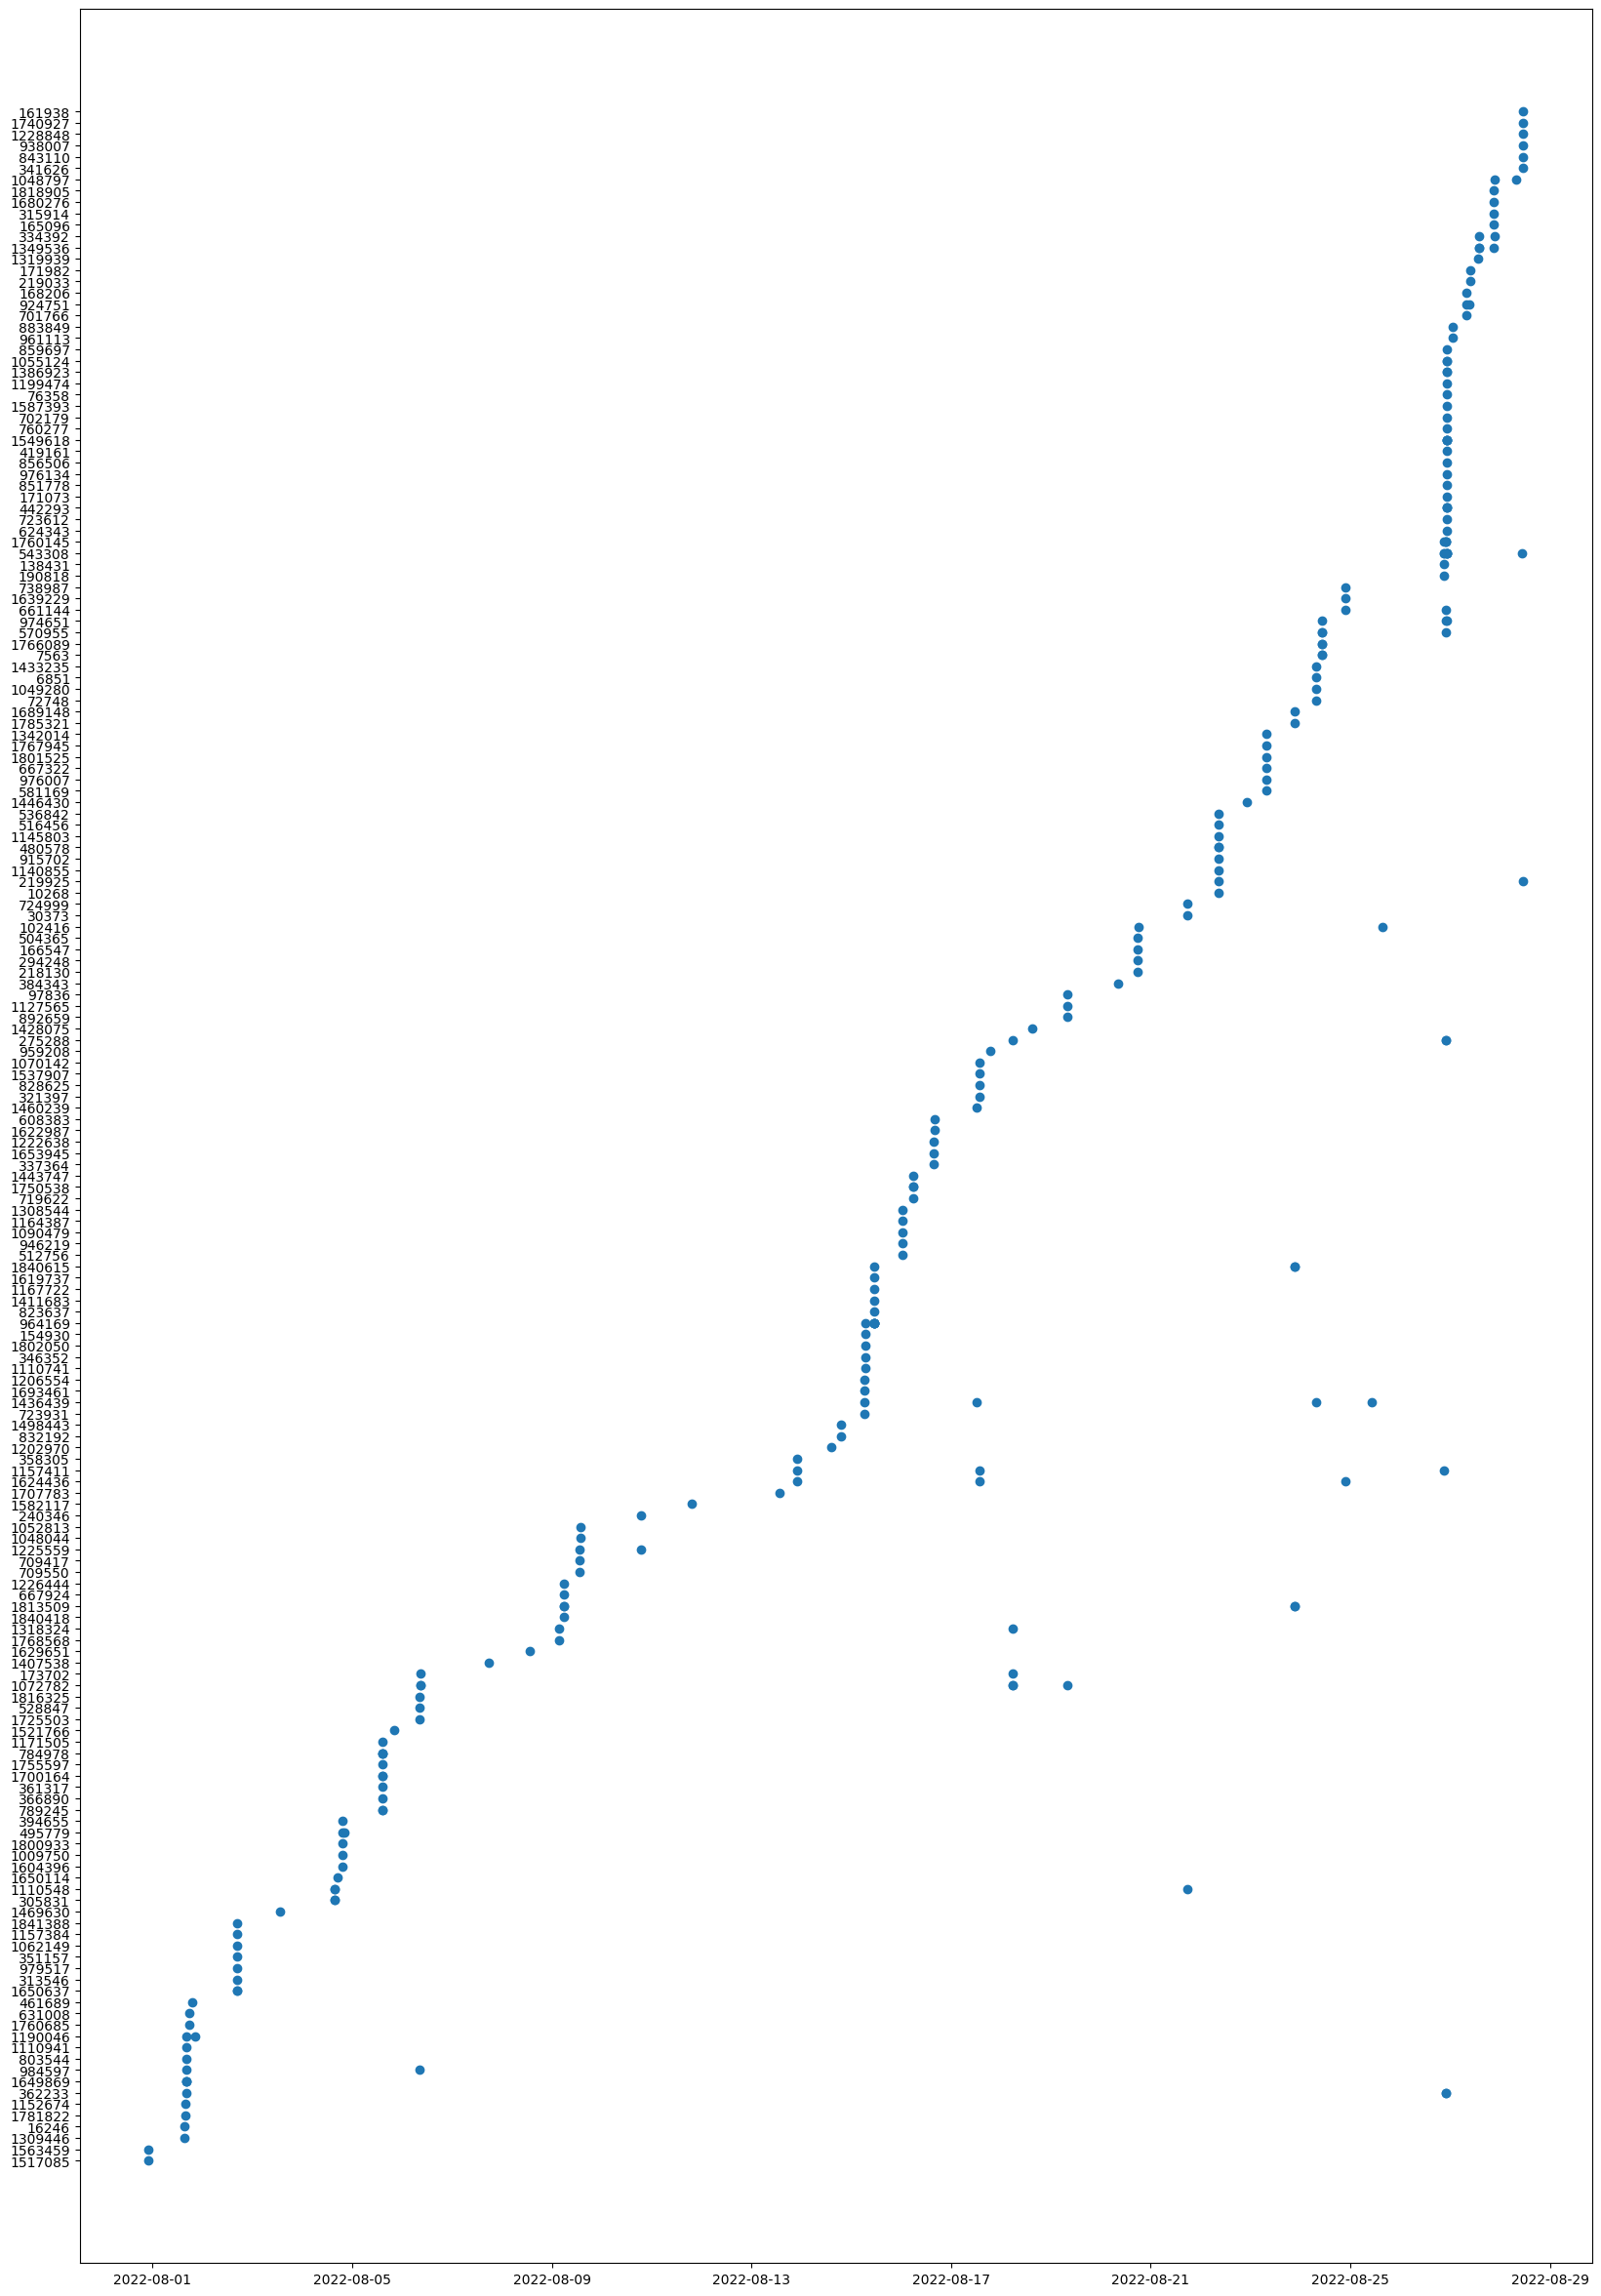

In [12]:
df_train_clicks = df_train[(df_train["session"] == 0) & (df_train["type"] == "clicks")]
plt.figure(figsize = (20, 30))
plt.scatter(df_train_clicks["ms"], df_train_clicks["aid"].astype("string"))
plt.show()

##### Orders

In [13]:
df_train[(df_train["session"] == 0) & (df_train["type"] == "orders")]

,session,aid,ts,type,ms,time_difference_seconds
0,0,305831,1659370027105,orders,2022-08-01 16:07:07.105,129.055
0,0,461689,1659370027105,orders,2022-08-01 16:07:07.105,0.000
0,0,1199474,1661552940651,orders,2022-08-26 22:29:00.651,146.196
0,0,543308,1661552940651,orders,2022-08-26 22:29:00.651,0.000


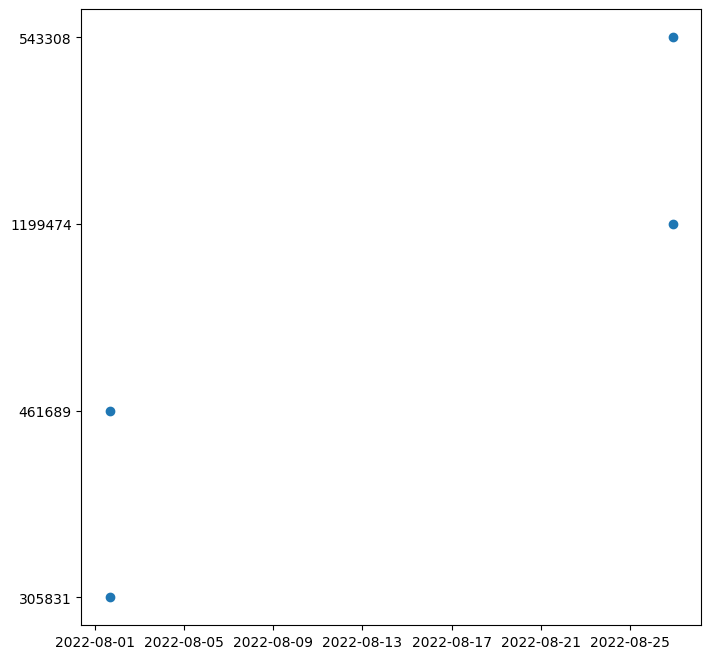

In [14]:
df_train_orders = df_train[(df_train["session"] == 0) & (df_train["type"] == "orders")]
plt.figure(figsize = (8, 8))
plt.scatter(df_train_orders["ms"], df_train_orders["aid"].astype("string"))
plt.show()

##### Carts

In [15]:
df_train[(df_train["session"] == 0) & (df_train["type"] == "carts")]

,session,aid,ts,type,ms,time_difference_seconds
0,0,1649869,1659369893840,carts,2022-08-01 16:04:53.840,2008.044
0,0,461689,1659369898050,carts,2022-08-01 16:04:58.050,4.210
0,0,789245,1659710157188,carts,2022-08-05 14:35:57.188,10.740
0,0,974651,1661336218155,carts,2022-08-24 10:16:58.155,11.329
0,0,974651,1661336225076,carts,2022-08-24 10:17:05.076,2.629
0,0,974651,1661336252514,carts,2022-08-24 10:17:32.514,27.438
0,0,280978,1661336260024,carts,2022-08-24 10:17:40.024,7.510
0,0,1521766,1661336265942,carts,2022-08-24 10:17:45.942,5.918
0,0,1760145,1661377467092,carts,2022-08-24 21:44:27.092,14.556
0,0,275288,1661550299698,carts,2022-08-26 21:44:59.698,2596.859


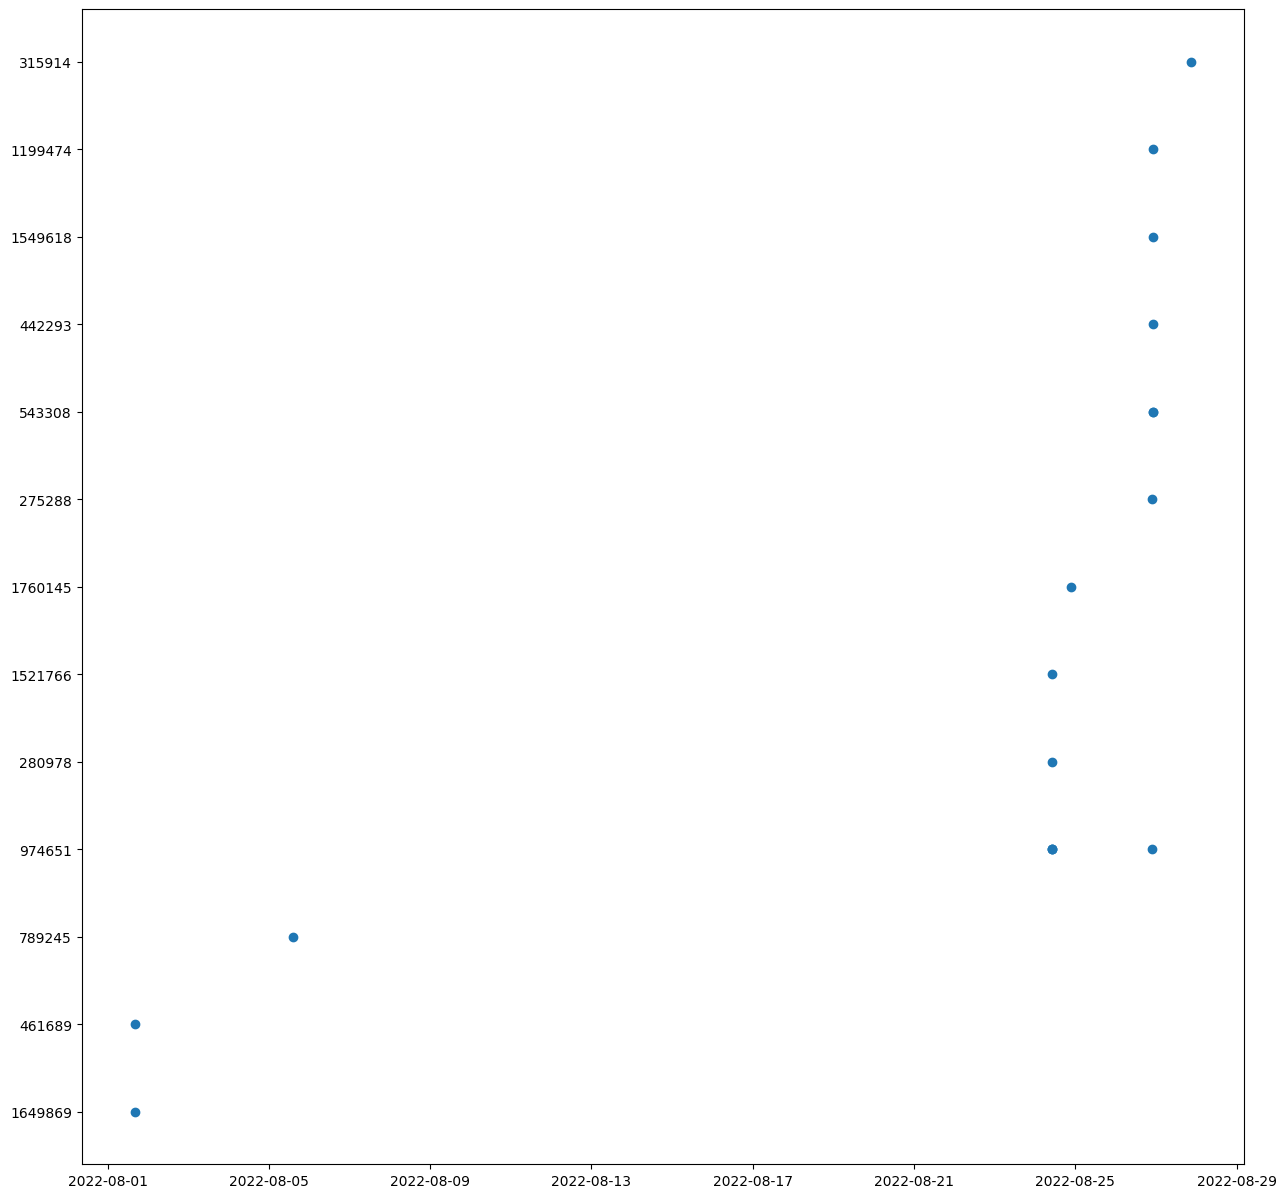

In [16]:
df_train_carts = df_train[(df_train["session"] == 0) & (df_train["type"] == "carts")]
plt.figure(figsize = (15, 15))
plt.scatter(df_train_carts["ms"], df_train_carts["aid"].astype("string"))
plt.show()